# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [2]:
from dps_lake_model import lake_model
import os
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)
from ema_workbench.analysis import prim
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.analysis import parcoords
import pandas as pd
from ema_workbench import load_results
import matplotlib.pyplot as plt
import numpy as np

from ema_workbench.em_framework import optimization
from ema_workbench.em_framework.samplers import sample_uncertainties

## Define robustness function definitions for all outcomes

In [6]:
import functools
#returns the percentage of the outcomes that are under a certain threshold
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

# def maxp(data, threshold, data):
#     return np.sum(data<=threshold)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)

In [22]:
# set levers, one for each time step
lake_m.levers = [RealParameter('c1', -2, 2),
                     RealParameter('c2', -2, 2),
                     RealParameter('r1', 0, 2),
                     RealParameter('r2', 0, 2),
                     RealParameter('w1', 0, 1)]

In [40]:
ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_m = Model('lakemodel', function=lake_model)

#specify uncertainties
lake_m.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_m.levers = [RealParameter('c1', -2, 2),
                     RealParameter('c2', -2, 2),
                     RealParameter('r1', 0, 2),
                     RealParameter('r2', 0, 2),
                     RealParameter('w1', 0, 1)]

#specify outcomes 
lake_m.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                 #How do we get these numbers? and what does it do? How does HyperVolume use it
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

## Create robustness funcion for optimize function

In [8]:
MAXIMIZE = ScalarOutcome.MAXIMIZE  # @UndefinedVariable
MINIMIZE = ScalarOutcome.MINIMIZE  # @UndefinedVariable

robustness_functions = [ ScalarOutcome('Fraction max_P', 
        kind=MINIMIZE,
        variable_name='max_P',
        function=maxp),
    ScalarOutcome(
        'Fraction utility',
        kind=MAXIMIZE,
        variable_name='utility',
        function=utility),
    ScalarOutcome(
        'Fraction reliability',
        kind=MAXIMIZE,
        variable_name='reliability',
        function=reliability),
   ScalarOutcome(
        'Fraction inertia',
        kind=MAXIMIZE,
        variable_name='inertia',
        function=inertia)]

In [9]:
%%time
from ema_workbench import (SequentialEvaluator, ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(lake_m) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=500, policies=4, uncertainty_sampling = 'mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 1min 31s


## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [11]:
convergence_metrics = [HyperVolume.from_outcomes(lake_m.outcomes),
                       EpsilonProgress()]

In [12]:
n_scenarios = 50
scenarios = sample_uncertainties(lake_m, n_scenarios)
nfe = 200


with MultiprocessingEvaluator(lake_m) as evaluator:
    results1, convergence1 = evaluator.robust_optimize(robustness_functions, scenarios, nfe=nfe,  convergence=convergence_metrics, 
                              epsilons=[0.05,0.05,0.05,0.05] )

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

Text(0, 0.5, 'hypervolume')

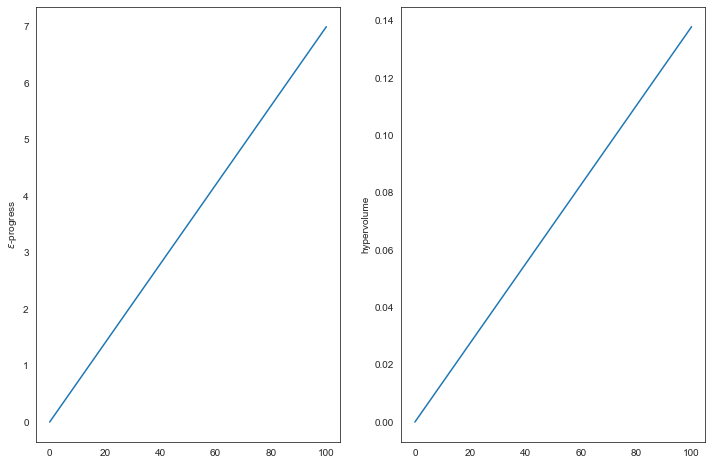

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,8))
ax[0].plot(convergence1.nfe, convergence1.epsilon_progress)
ax[0].set_ylabel('$\epsilon$-progress')

ax[1].plot(convergence1.nfe, convergence1.hypervolume)
ax[1].set_ylabel('hypervolume')

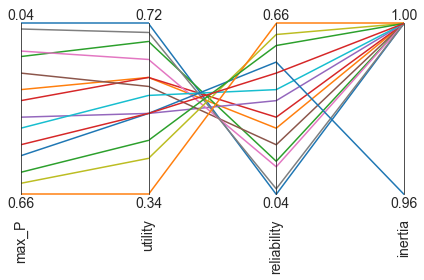

In [49]:
outcomes = results1.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [17]:
from ema_workbench import Policy

In [36]:
policies_df = results1[['c1', 'c2', 'r1', 'r2', 'w1']]
policies = []

for i,policy in policies_df.iterrows():
    policies.append(Policy(str(i),**policy.to_dict()))

In [41]:
%%time
from ema_workbench import (SequentialEvaluator, ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(lake_m) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=policies)

[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished


Wall time: 16min 25s


In [43]:
nfe = 200
n_scenarios = 50
scenarios = sample_uncertainties(lake_m, n_scenarios)

with MultiprocessingEvaluator(lake_m) as evaluator:
    results1, convergence1 = evaluator.robust_optimize(robustness_functions, scenarios, nfe=nfe,  convergence=convergence_metrics, 
                              epsilons=[0.05,0.05,0.05,0.05])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


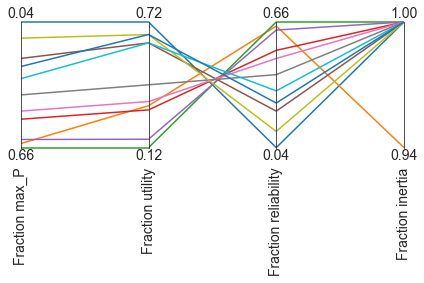

In [48]:
outcomes = results1.loc[:, ['Fraction max_P', 'Fraction utility', 'Fraction reliability', 'Fraction inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('Fraction max_P') 
plt.show()

Unable to run it for more than 200 runs because of computational difficulties

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?